In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob

from astropy.io import fits
from keckcode_test.keckcode.esiredux import esi2d, esi1d
from specim_test.specim.specfuncs import spec2d, spec1d, echelle1d
from scipy.ndimage import map_coordinates, shift

In [2]:
file_loc = '../galaxy_spectra/ESI_data/*'

In [3]:
spec2d_file_list = []
var2d_file_list = []
#out_file = []
for i,p in enumerate(glob.glob(file_loc)):
    if 'J0053' in p:
        if 'bgsub.fits' in p:
            spec2d_file_list.append(p)
        elif 'var.fits' in p:
            var2d_file_list.append(p)

In [4]:
spec2d_file_list, var2d_file_list

(['../galaxy_spectra/ESI_data/J0053-2012_0028_bgsub.fits',
  '../galaxy_spectra/ESI_data/J0053-2012_0030_bgsub.fits',
  '../galaxy_spectra/ESI_data/J0053-2012_0029_bgsub.fits'],
 ['../galaxy_spectra/ESI_data/J0053-2012_0029_var.fits',
  '../galaxy_spectra/ESI_data/J0053-2012_0028_var.fits',
  '../galaxy_spectra/ESI_data/J0053-2012_0030_var.fits'])

In [3]:
# create a list of spec2d object for particular order
spec1 = esi2d.Esi2d(spec2d_file_list[0], varfile=var2d_file_list[1])
spec2 = esi2d.Esi2d(spec2d_file_list[2], varfile=var2d_file_list[0])
spec3 = esi2d.Esi2d(spec2d_file_list[1], varfile=var2d_file_list[2])

NameError: name 'esi2d' is not defined

In [2]:
pixrange = [[2200, 2600], [2700, 3000], [2600, 3000], [1800, 2200], [1500, 1900], [1500, 1900], [800, 1200]]
spec_list = [spec1, spec2, spec3]
order_list = spec1.ordinfo

for order, pix in zip(order_list[3:], pixrange):
    print(order['name'], 'pixscale:', order['pixscale'])
    for sp in spec_list:
        profile = sp[order['order']-1].spatial_profile(pixrange=pix)
        plt.show()
        sp[order['order']-1].initial_model()

NameError: name 'spec1' is not defined

In [8]:
order_list = [4, 5, 6, 7, 8, 9, 10]
spec_list = [spec1, spec2, spec3]
shifted_sp = []
shifted_var = []
shift_pixel = np.array([[0.82, -35.07, 36.61], [0.14, -34.18, 34.61], [0.24, -32.52, 33.15],
                        [0.06, -32.10, 32.22], [0.78, -31.50, 31.50], [0.25, -30.33, 30.22],
                        [0.54, -29.91, 29.15]])
for shft, order in zip(shift_pixel, order_list):
    new_sp = []
    new_var = []
    for i, sp in enumerate(spec_list):
        #print(sp[order-1].mod0, shift[i])
        nanmask = (sp[order-1].vardata <= 0) | (np.isnan(sp[order-1].vardata)) 
        nnan = nanmask.sum()
        if nnan > 0:
            print('Found %d NaNs in the two-dimensional variance '\
                  'spectrum' % nnan)

            """ Replace the NaNs with a big value """
            sp[order-1].vardata[nanmask] = 1.e9
        new_sp.append(shift(sp[order-1].data, [shft[i], 0], order=1))
        new_var.append(shift(sp[order-1].vardata, [shft[i], 0], order=1))
    shifted_sp.append(new_sp)
    shifted_var.append(new_var)

Found 1559 NaNs in the two-dimensional variance spectrum
Found 1651 NaNs in the two-dimensional variance spectrum
Found 1411 NaNs in the two-dimensional variance spectrum
Found 1586 NaNs in the two-dimensional variance spectrum
Found 1409 NaNs in the two-dimensional variance spectrum
Found 1443 NaNs in the two-dimensional variance spectrum
Found 1368 NaNs in the two-dimensional variance spectrum
Found 1325 NaNs in the two-dimensional variance spectrum
Found 1509 NaNs in the two-dimensional variance spectrum
Found 955 NaNs in the two-dimensional variance spectrum
Found 1239 NaNs in the two-dimensional variance spectrum
Found 1189 NaNs in the two-dimensional variance spectrum
Found 1291 NaNs in the two-dimensional variance spectrum
Found 1287 NaNs in the two-dimensional variance spectrum
Found 1439 NaNs in the two-dimensional variance spectrum
Found 1340 NaNs in the two-dimensional variance spectrum
Found 1315 NaNs in the two-dimensional variance spectrum
Found 1419 NaNs in the two-dimen

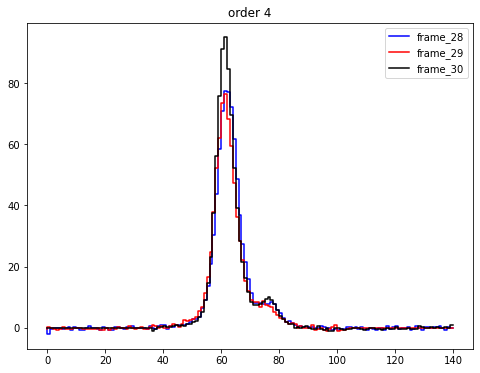

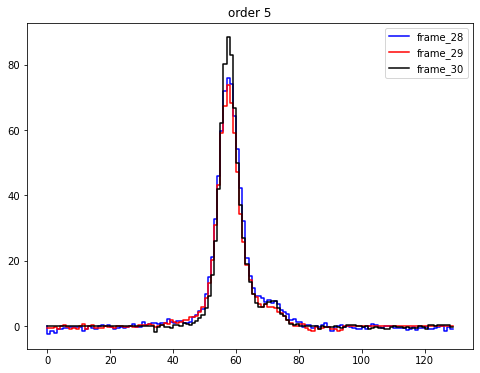

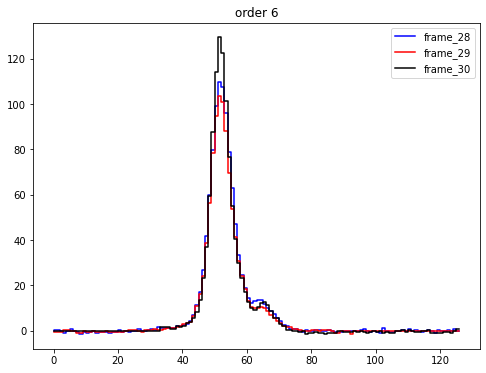

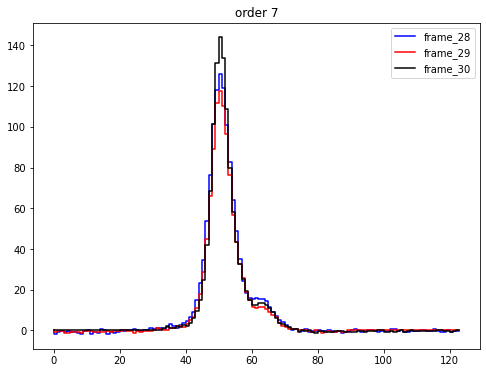

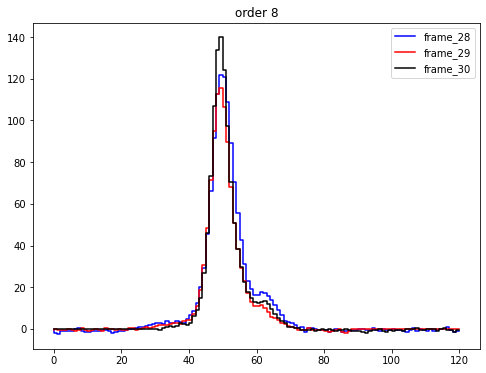

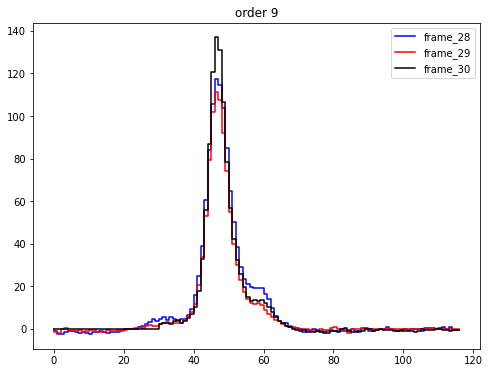

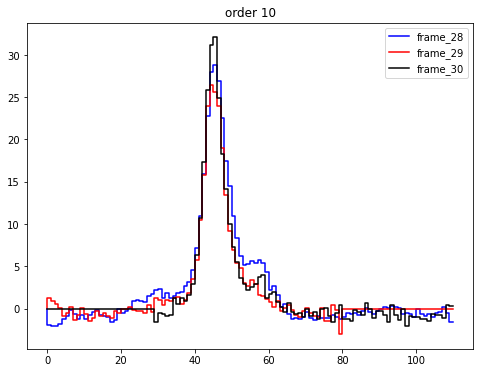

In [9]:
for od, sp_list, pix in zip(order_list, shifted_sp, pixrange):
    plt.figure(figsize=(8, 6))
    #pixrange = [[2200, 2600], [2200, 2600], [1800, 2200], [1500, 1900], [1500, 1900], [1500, 1900]]
    color = ['b', 'r', 'k']
    label = ['frame_28', 'frame_29', 'frame_30']
    for i, p in enumerate(sp_list):
        tmpdata = p[:, pix[0]:pix[1]]
        pflux = np.median(tmpdata, axis=1)
        x = np.arange(p.shape[0])
        plt.plot(x, pflux, color=color[i], drawstyle='steps', label=label[i])
    plt.legend()
    plt.title('order %d' %od)

In [10]:
outsp = []
outvar = []

for sp_list, var_list in zip(shifted_sp, shifted_var):
    wtsp = np.zeros(sp_list[0].shape)
    wtsum = np.zeros(sp_list[0].shape)
    for s, v in zip(sp_list, var_list):
        wt = np.zeros(wtsp.shape)
        mask = np.isnan(v) | (v<=0)
        wt[~mask] = 1.0 / v[~mask]
        #print(sum(sum(np.isnan(wt) | (wt<=0))))
        wtsp += wt * s
        #print(sum(sum(wtsp==0)))
        wtsum += wt
        #print(sum(sum(wtsum==0)))

    wtsp[wtsum == 0] = 0
    wtsum[wtsum == 0] = 1
    outsp.append(wtsp / wtsum)
    outvar.append(1.0 / wtsum)

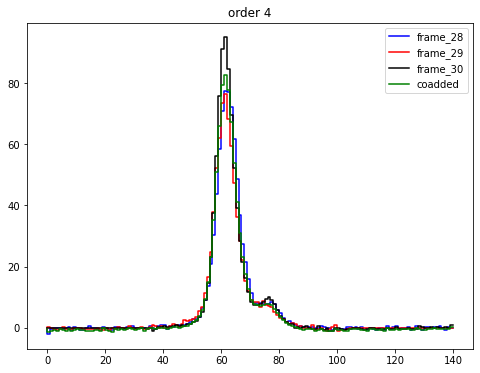

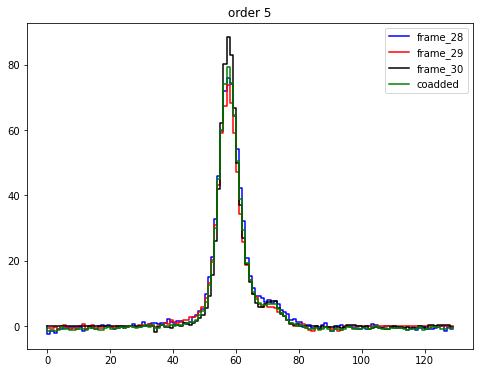

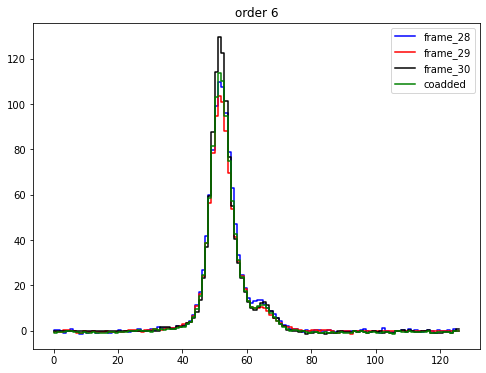

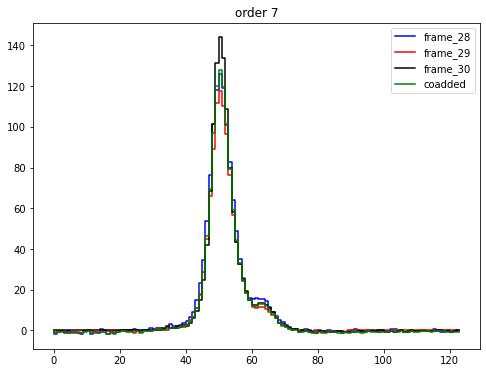

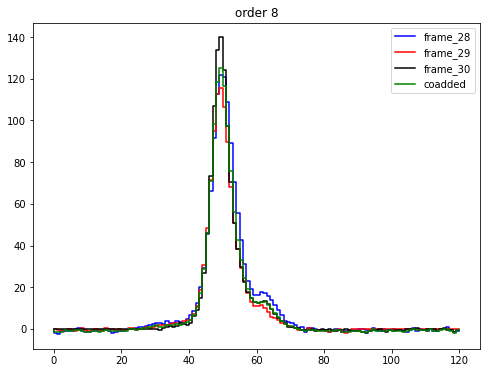

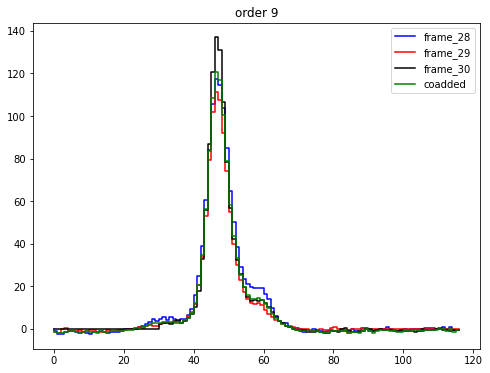

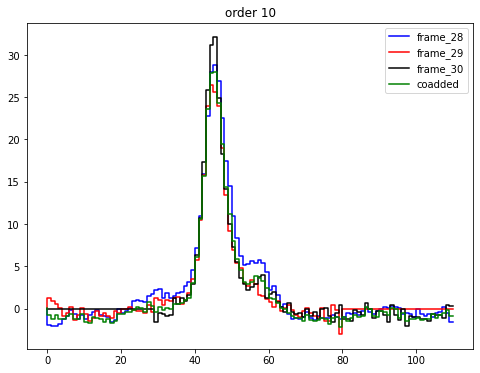

In [13]:
pixrange = [[2200, 2600], [2700, 3000], [2600, 3000], [1800, 2200], [1500, 1900], [1500, 1900], [1500, 1900]]
for od, sp_list, cd_sp, pix in zip(order_list, shifted_sp, outsp, pixrange):
    plt.figure(figsize=(8, 6))
    #pixrange = [2700, 3000]
    color = ['b', 'r', 'k']
    label = ['frame_28', 'frame_29', 'frame_30']
    for i, p in enumerate(sp_list):
        tmpdata = p[:, pix[0]:pix[1]]
        pflux = np.median(tmpdata, axis=1)
        x = np.arange(p.shape[0])
        plt.plot(x, pflux, color=color[i], drawstyle='steps', label=label[i])
    
    tmpdata = cd_sp[:, pix[0]:pix[1]]
    pflux = np.median(tmpdata, axis=1)
    x = np.arange(cd_sp.shape[0])
    plt.plot(x, pflux, color='g', drawstyle='steps', label='coadded')
    plt.legend()
    plt.title('order %d' %od)

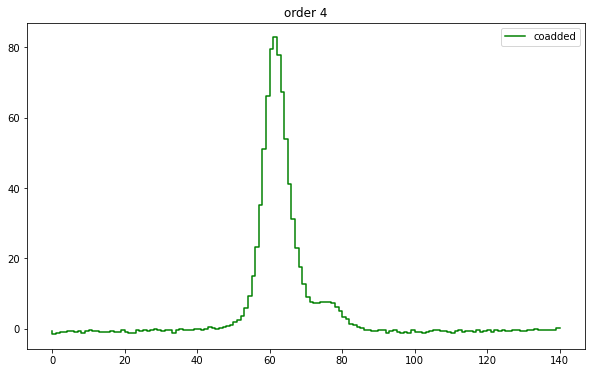

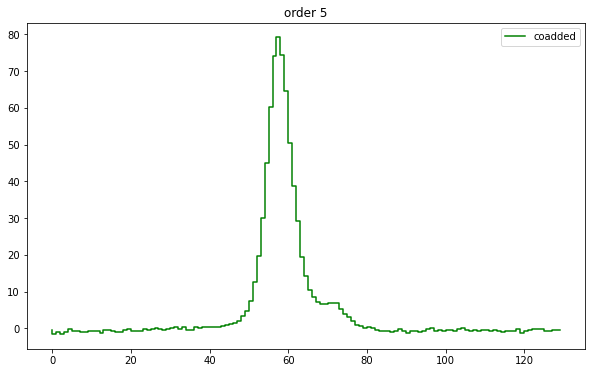

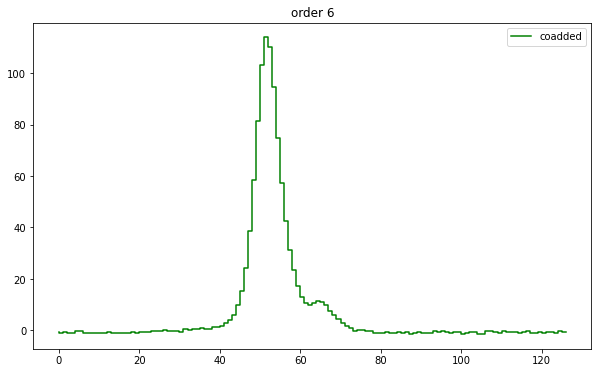

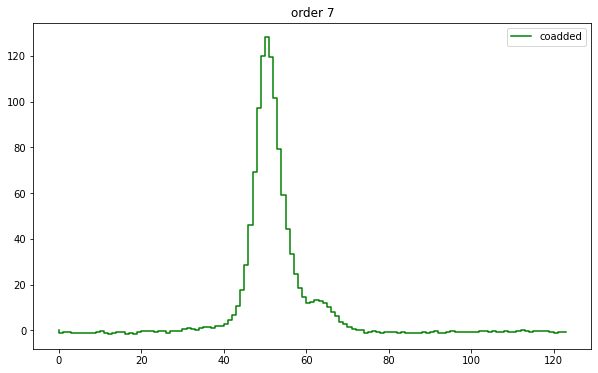

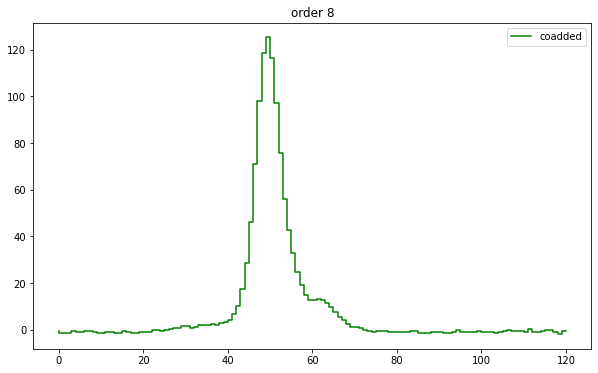

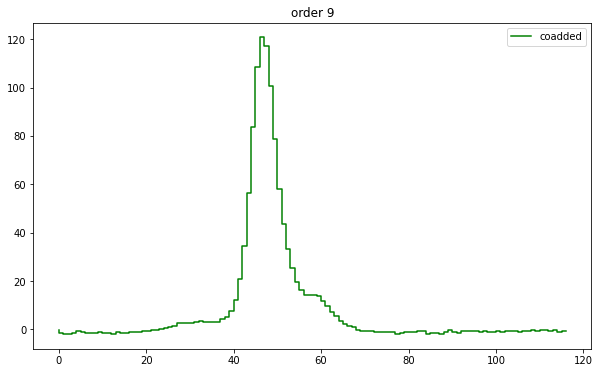

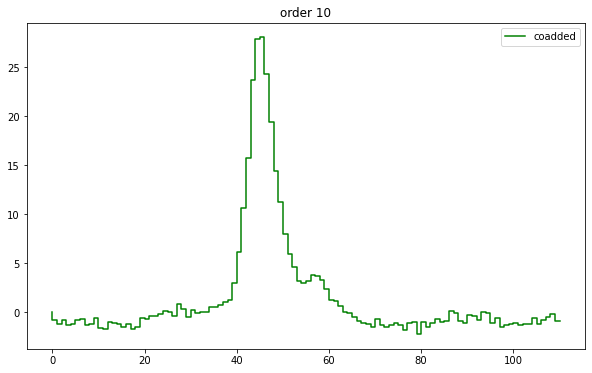

In [14]:
for od, cd_sp, pix in zip(order_list, outsp, pixrange):
    plt.figure(figsize=(10, 6))
    tmpdata = cd_sp[:, pix[0]:pix[1]]
    pflux = np.median(tmpdata, axis=1)
    x = np.arange(cd_sp.shape[0])
    plt.plot(x, pflux, color='g', drawstyle='steps', label='coadded')
    plt.legend()
    plt.title('order %d' %od)

In [15]:
s = fits.open('../galaxy_spectra/ESI_data/J0053-2012_0028_bgsub.fits')
for od, cd_sp, cd_var in zip(order_list, outsp, outvar):
    file_name1 = 'J0053_ESI_spectra/J0053_coadd2d_sp_order_' + str(od) + '.fits'
    file_name2 = 'J0053_ESI_spectra/J0053_coadd2d_var_order_' + str(od) + '.fits'
    fits.writeto(file_name1, cd_sp, header=s[od].header)
    fits.writeto(file_name2, cd_var, header=s[od].header)